In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU

## Utils

In [153]:
def deal_with_nans(df, dropna=True):
    method = 'linear'
    limit = 3
    df_clean = df.interpolate(method=method, limit=limit)
    if dropna:
        df_clean = df_clean.dropna()
    return df_clean

def feature_selector(df, features, labels):
    X = df[features]
    y = df[labels]
    return X, y


def time_spliter(X, y, train_start, train_end, test_start, test_end):
    X_train = X[train_start:train_end]
    X_test = X[test_start:test_end] 
    y_train = y[train_start:train_end]
    y_test = y[test_start:test_end] 
    return X_train, X_test, y_train, y_test

def accuracy(label, prediction):
    # Explained variance score: 1 is perfect prediction
    print("RMSE: %.2f" % ((1 - (np.sqrt(mean_squared_error(label, prediction) / (label.max()[0] - label.min()[0]))))*100))
    print("MAE: %.2f" % ((1 - (mean_absolute_error(label, prediction) / (label.max()[0] - label.min()[0])))*100))
    print("r score : %.2f" % r2_score(label, prediction))

def plot_model(label, prediction):
    combination = label.copy()
    combination['pred'] = prediction
    combination.plot(figsize=(15,5))

def show_results(label, prediction):
    accuracy(label, prediction)
    plot_model(label, prediction)
    plt.show()

### FUNCTION TO PIVOT DATA TO PREVIOUS AND FUTURE STEPS

In [122]:
def temporal_pivot(df, n_past, n_future, dropna=True):
    n_vars = df.shape[1]
    cols, names = list(), list()
    # past samples
    for i in range(n_past, 0, -1):
        cols.append(df.shift(i))
        names += [('{0}(t-{1})'.format(df.columns[j],i))  for j in range(n_vars)]
    # present and future samples
    for i in range(0, n_future):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('{0}(t)'.format(df.columns[j]))  for j in range(n_vars)]
        else:
            names += [('{0}(t+{1})'.format(df.columns[j],i))  for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropna:
        agg.dropna(inplace=True)
    return agg

### START WORKING WITH ENEA DATA

In [123]:
input_data_path = '/home/marcroig/sensor_calibration/ENEA/data/enea_sensors_with_nans.csv'
output_data_path = None

features = ['co','rh']
labels = ['co_ref']

index_col = None

train_start = 0
train_end = 24*7*4*2 # day_hours * days_per_week * weeks_per_month * months
test_start = train_end + 1 
test_end = test_start + 24*7*4*6

temporal_features = ['co(t-1)', 'rh(t-1)', 'co(t)', 'rh(t)']
#temporal_features = ['no2(t-1)', 'o3(t-1)', 'no2(t)', 'o3(t)']
temporal_labels = ['co_ref(t)']

We have to take into account that temporal gaps are meaningfull. In this case we want to keep NaN values because they represent a temporal gap between two samples. NaN values will be deleted after temporal pivoting, to make sure that we only keep consecutive data.

In [124]:
df = pd.read_csv(input_data_path, index_col=index_col)

df_subset = df[features + labels]

df_clean = deal_with_nans(df_subset, dropna=False)

df_clean.head()

,co,rh,co_ref
0,1360.00,48.875001,2.6
1,1292.25,47.700000,2.0
2,1402.00,53.975000,2.2
3,1375.50,60.000000,2.2
4,1272.25,59.575001,1.6


### TEMPORAL PIVOTING

In [125]:
n_past=1
n_future=1

df_pivot = temporal_pivot(df_clean, n_past, n_future, dropna=True)

df_pivot.head()

,co(t-1),rh(t-1),co_ref(t-1),co(t),rh(t),co_ref(t)
1,1360.00,48.875001,2.6,1292.25,47.700000,2.0
2,1292.25,47.700000,2.0,1402.00,53.975000,2.2
3,1402.00,53.975000,2.2,1375.50,60.000000,2.2
4,1375.50,60.000000,2.2,1272.25,59.575001,1.6
5,1272.25,59.575001,1.6,1197.00,59.175000,1.2


In [126]:
'''
def get_temporal_columns():
    temporal_features = []
    for t in range(-n_past,1):
        for feature in features:
            if t == 0:
                temporal_features.append((feature + '(t)'))
            else:
                temporal_features.append(feature + '(t' + str(t) + ')')
    return temporal_features
'''
    

X, y = feature_selector(df_pivot, temporal_features, temporal_labels)

### SPLIT, NORMALIZE and 3D RESHAPE

In [127]:
X_train, X_test, y_train, y_test = time_spliter(X, y, train_start, train_end, test_start, test_end)

normalizer = StandardScaler()
normalizer.fit(X_train)
X_train = normalizer.transform(X_train)
X_test = normalizer.transform(X_test)

In [128]:
normalizer = StandardScaler()
normalizer.fit(y_train)
y_train = normalizer.transform(y_train)
y_test = normalizer.transform(y_test)

In [129]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_past + 1, len(features)))
X_test = X_test.reshape((X_test.shape[0], n_past + 1, len(features)))

print(X_train.shape)
print(X_test.shape)

(1344, 2, 2)
(4032, 2, 2)


### GRU MODEL

In [130]:
# design network
model = Sequential()
model.add(GRU(units=50,  activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
#model.add(Dense(units=20, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=80, batch_size=50, verbose=2, shuffle=False, validation_data=(X_test, y_test))

Train on 1344 samples, validate on 4032 samples
Epoch 1/80
 - 2s - loss: 0.6522 - val_loss: 0.6550
Epoch 2/80
 - 0s - loss: 0.5202 - val_loss: 0.5422
Epoch 3/80
 - 0s - loss: 0.4199 - val_loss: 0.4812
Epoch 4/80
 - 0s - loss: 0.3617 - val_loss: 0.4266
Epoch 5/80
 - 0s - loss: 0.3355 - val_loss: 0.3952
Epoch 6/80
 - 0s - loss: 0.3281 - val_loss: 0.3878
Epoch 7/80
 - 0s - loss: 0.3188 - val_loss: 0.3840
Epoch 8/80
 - 0s - loss: 0.3112 - val_loss: 0.3811
Epoch 9/80
 - 0s - loss: 0.3043 - val_loss: 0.3774
Epoch 10/80
 - 0s - loss: 0.2985 - val_loss: 0.3729
Epoch 11/80
 - 0s - loss: 0.2942 - val_loss: 0.3694
Epoch 12/80
 - 0s - loss: 0.2890 - val_loss: 0.3644
Epoch 13/80
 - 0s - loss: 0.2868 - val_loss: 0.3612
Epoch 14/80
 - 0s - loss: 0.2852 - val_loss: 0.3603
Epoch 15/80
 - 0s - loss: 0.2834 - val_loss: 0.3599
Epoch 16/80
 - 0s - loss: 0.2815 - val_loss: 0.3592
Epoch 17/80
 - 0s - loss: 0.2805 - val_loss: 0.3598
Epoch 18/80
 - 0s - loss: 0.2780 - val_loss: 0.3570
Epoch 19/80
 - 0s - loss:

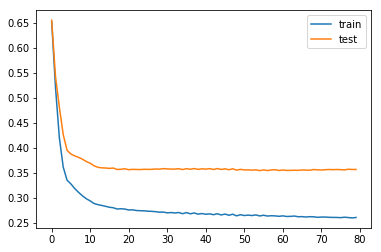

In [135]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

RMSE: 85.66
MAE: 95.69
r score : 0.88


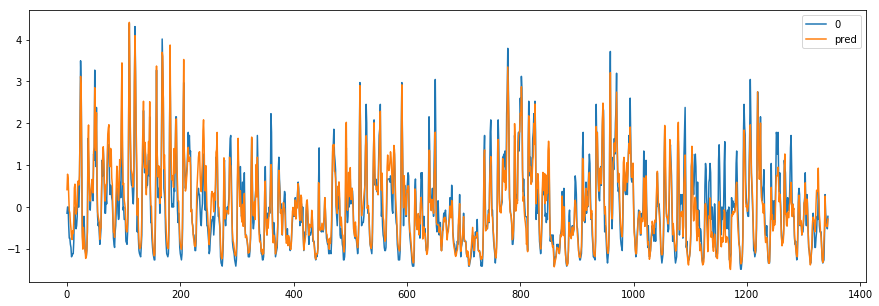

In [154]:
p_train = model.predict(X_train)
show_results(pd.DataFrame(y_train), p_train)

RMSE: 82.35
MAE: 95.94
r score : 0.78


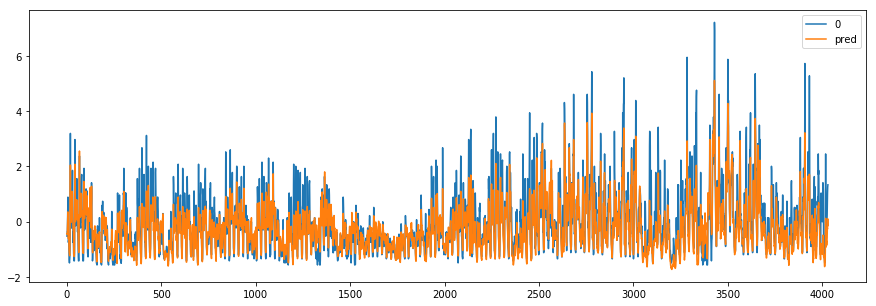

In [155]:
p_test = model.predict(X_test)
show_results(pd.DataFrame(y_test), p_test)